In [1]:
#from IPython.core.magic import register_line_magic

#@register_line_magic
##3def pip(args):
    #"""Use pip from the current kernel"""
    #from pip import main
    #main(args.split())

In [1]:
##%pip install yahoo_fin --upgrade
##%pip install requests_html
#!pip uninstall -y yfinance
#%pip install yfinance --upgrade --no-cache-dir
#pip install get-all-tickers
#%pip install reticker

In [2]:
import os
import pandas as pd
import numpy as np
import datetime as dt
##import yfinance as yf
import re
import requests
from bs4 import BeautifulSoup
#import reticker
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
##data = yf.download(tickers = "gme", period="2y", interval = "1h")
##data.head()

####Match the dollar sign, one letter, and then anything that's not a space:

## for i in df["title"][:20]:
    ##print(re.findall(r'[$][A-Za-z][\S]*', str(i)))

##extractor = reticker.TickerExtractor()

##for i in df["title"][:20]:
    ##print(extractor.extract(i))

In [4]:
df=pd.read_csv("reddit_wsb.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      53187 non-null  object 
 1   score      53187 non-null  int64  
 2   id         53187 non-null  object 
 3   url        53187 non-null  object 
 4   comms_num  53187 non-null  int64  
 5   created    53187 non-null  float64
 6   body       24738 non-null  object 
 7   timestamp  53187 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.2+ MB


In [6]:
#convert date column to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'], 
                                    format='%Y-%m-%dT%H:%M:%S.%f')
df.dtypes

title                object
score                 int64
id                   object
url                  object
comms_num             int64
created             float64
body                 object
timestamp    datetime64[ns]
dtype: object

In [7]:
##creating year, mont, dayofweek, hour, min, second columns for eda
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['min'] = df['timestamp'].dt.minute
df['sec'] = df['timestamp'].dt.second

##we can get name of the days if we need to.
##dayoftheweek = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
##days = list(dayoftheweek.values())
##df['day'] = df['timestamp'].apply(lambda x : dayoftheweek[x.weekday()])

In [8]:
df["body"] = df["body"].fillna("")##fill nan's with empty
df["original_text"] = df["title"] + ' ' + df["body"]##concatane body and title to create a new column called text
df['length'] = df['original_text'].apply(len) #create new column with the length of the text
df = df.drop(columns = ["body", "title", "id", "url", "created"])##drop unrelated columns

In [9]:
df.head()

,score,comms_num,timestamp,year,month,day,hour,min,sec,original_text,length
0,55,6,2021-01-28 21:37:41,2021,1,3,21,37,41,"It's not about the money, it's about sending a...",60
1,110,23,2021-01-28 21:32:10,2021,1,3,21,32,10,Math Professor Scott Steiner says the numbers ...,81
2,0,47,2021-01-28 21:30:35,2021,1,3,21,30,35,Exit the system The CEO of NASDAQ pushed to ha...,1335
3,29,74,2021-01-28 21:28:57,2021,1,3,21,28,57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,76
4,71,156,2021-01-28 21:26:56,2021,1,3,21,26,56,"Not to distract from GME, just thought our AMC...",80


In [10]:
def clean_text_date(text):
    text = text.lower()
    
    # remove emojis
    text = text.encode('ascii','ignore')
    text = text.decode()

    # replacing handlers with empty string
    text = re.sub('@[^\s]+',"",text)
    
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # replacing single characters with empty string
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in set(stopwords.words('english'))])
    
    # words to singular forms
    lem = WordNetLemmatizer()
    text = lem.lemmatize(text)
    
    return text

In [11]:
# Text Preprocessing
df["text"] = df["original_text"].apply(lambda x : clean_text_date(x))

In [12]:
df.head()

,score,comms_num,timestamp,year,month,day,hour,min,sec,original_text,length,text
0,55,6,2021-01-28 21:37:41,2021,1,3,21,37,41,"It's not about the money, it's about sending a...",60,money sending message
1,110,23,2021-01-28 21:32:10,2021,1,3,21,32,10,Math Professor Scott Steiner says the numbers ...,81,math professor scott steiner says numbers spel...
2,0,47,2021-01-28 21:30:35,2021,1,3,21,30,35,Exit the system The CEO of NASDAQ pushed to ha...,1335,exit system ceo nasdaq pushed halt trading giv...
3,29,74,2021-01-28 21:28:57,2021,1,3,21,28,57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,76,new sec filing gme someone less retarded pleas...
4,71,156,2021-01-28 21:26:56,2021,1,3,21,26,56,"Not to distract from GME, just thought our AMC...",80,distract gme thought amc brothers aware


In [13]:
sum (df['text'].str.contains('bullish'))

1056

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [15]:
a = 'bull'
sia.polarity_scores(a)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [16]:
df["neg"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [27]:
scores = {"neg":0, "neu":0, "11-100":0, "pos":0}

for i in df["compound"]:
    if i < -0.2:
        scores["neg"] += 1
    elif i < 0.2:
        scores["neu"] += 1
    else:
        scores["pos"] += 1

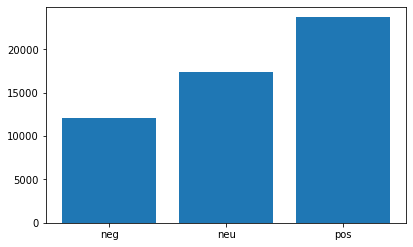

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
score_label = ["neg", "neu", "pos"]
value = [scores["neg"], scores["neu"], scores["pos"]]
ax.bar(score_label, value)
plt.show()

In [19]:
new_words = {
'citron': -4.0,  
'hidenburg': -4.0,
'green': 2.0,
'hot': 2.0,
'squeeze': 2.0,
'ape': 2.0,
'apes': 2.0,
'apes together strong': 3.0,
'roaring kitty': 2.0,
'bull': 4.0,
'bullish': 4.0,
'bear': -4.0,
'bearish': 4.0,
'bag holder': -3.0,
'bagholder': -3.0,
'bag holding': -3.0,
'bagholding': -3.0,
'hold': 2.0,
'hold the line': 3.0,
'diamond': 3.0,
'diamond hands': 3.0,
'paper hands': -3.0,
'weak hands': -3.0,
'DD': 2.0,
'double Down': 2.0,
'due diligence': 2.0,
'pump': -2.0,
'pumping': -2.0,
'dump': -2.0,
'pump and dump': -3.0,
'stonk': 2.0,
'stonks': 2.0,
'tendie' : 2.0,
'tendies': 3.0,
'YOLO': 2.0,
'moon': 3.0,
'mooning': 3.0,
'to the moon': 4.0,
'long': 2.0,
'short': -2.0,
'call': 4.0,
'calls': 4.0,
'put': -4.0,
'puts': -4.0,
'overvalued': -3.0,
'undervalued': 3.0,
'low': -2.0,
'high': 2.0,
'buy': 4.0,
'sell': -4.0,
'buy high sell low': -4.0,
'buy the dip': 3.0,
'drop': -3.0,
'rebound': 3.0,
'green': 2.0,
'rip': -3.0,
'offering': 2.0,
'rocket': 3.0,
'break': 2.0,
'we like the stock': 4.0,
'ATH': 4.0,
'IRS': -2.0,
'SEC': -3.0,
'RH': -2.0,
'robinhood': -2.0,
'IPO': 2.0,
'degenerates': -3.0,
'Stimmy': 1.5,
'checks' : 1.0,
'stimmy checks': 2.0,
'loss': -3.0,
'loss porn': -4.0,
'gain': 3.0,
'gain porn': 3.0,
'whale' : -1.0,
'HODL' : 3.0,
'autist': 2.0,
'gamestonk': 2.0,
'crayons': 2.0,
'I eat crayons': 2.0,
'boyfriend': 1.0,
'FOMO': -2.0,
'hedge': -2.0,
'hedgies': -2.0,
'hedge funds': -3.0,
'retard': 2.0,
'retards': 3.0
}

In [20]:
sia.lexicon.update(new_words)

In [21]:
a = 'i like citron'
sia.polarity_scores(a)

{'neg': 0.667, 'neu': 0.0, 'pos': 0.333, 'compound': -0.5423}

In [22]:
df["neg_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [29]:
scores = {"neg_":0, "neu_":0, "pos_":0}

for i in df["compound_"]:
    if i < -0.2:
        scores["neg_"] += 1
    elif i < 0.2:
        scores["neu_"] += 1
    else:
        scores["pos_"] += 1

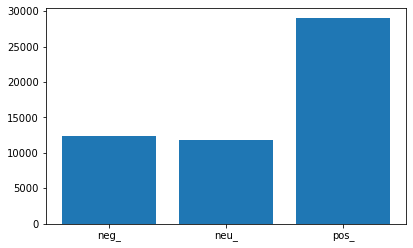

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
score_label = ["neg_", "neu_", "pos_"]
value = [scores["neg_"], scores["neu_"], scores["pos_"]]
ax.bar(score_label, value)
plt.show()